# Time series classification 

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import matplotlib.pyplot as plt
import mne

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper
import initialization_functions

from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

2022-09-28 09:59:42.743156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 09:59:42.846371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-28 09:59:42.876732: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 09:59:43.393063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [3]:
metadata.head()

,eeg_file,ParticipantID,test,sex,age_months,dyslexic_parent,Group_AccToParents,path_eeg,path_epoch,path_eventmarkers,epoch_file
0,105a,105,a,f,17,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,105a_epo.fif
1,107a,107,a,f,16,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,107a_epo.fif
2,106a,106,a,m,19,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,106a_epo.fif
3,109a,109,a,m,21,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,109a_epo.fif
4,110a,110,a,m,17,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,110a_epo.fif


In [4]:
metadata['Group_AccToParents'] = np.where(
    (metadata['Group_AccToParents']=='At risk'), 1,0)

# Get input data

In [5]:
control_files= metadata.loc[metadata['Group_AccToParents'] == 0]
atrisk_files = metadata.loc[metadata['Group_AccToParents'] == 1]

In [6]:
control = initialization_functions.read_filtered_data(control_files, to_array=False)

Checking out file: 117a_epo.fif
Checking out file: 118a_epo.fif
Checking out file: 119a_epo.fif
Checking out file: 124a_epo.fif
Checking out file: 127a_epo.fif
Checking out file: 126a_epo.fif
Checking out file: 131a_epo.fif
Checking out file: 135a_epo.fif
Checking out file: 133a_epo.fif
Checking out file: 138a_epo.fif
Checking out file: 139a_epo.fif
Checking out file: 144a_epo.fif
Checking out file: 143a_epo.fif
Checking out file: 146a_epo.fif
Checking out file: 145a_epo.fif
Checking out file: 154a_epo.fif
Checking out file: 153a_epo.fif
Checking out file: 168a_epo.fif
Checking out file: 177a_epo.fif
Checking out file: 190a_epo.fif
Checking out file: 170a_epo.fif
Checking out file: 174a_epo.fif
Checking out file: 191a_epo.fif
Checking out file: 169a_epo.fif
Checking out file: 173a_epo.fif
Checking out file: 166a_epo.fif
Checking out file: 216a_epo.fif
Checking out file: 175a_epo.fif
Checking out file: 172a_epo.fif
Checking out file: 183a_epo.fif
Checking out file: 185a_epo.fif
Checking

In [7]:
atrisk = initialization_functions.read_filtered_data(atrisk_files, to_array=False)

Checking out file: 105a_epo.fif
Checking out file: 107a_epo.fif
Checking out file: 106a_epo.fif
Checking out file: 109a_epo.fif
Checking out file: 110a_epo.fif
Checking out file: 112a_epo.fif
Checking out file: 111a_epo.fif
Checking out file: 114a_epo.fif
Checking out file: 115a_epo.fif
Checking out file: 116a_epo.fif
Checking out file: 123a_epo.fif
Checking out file: 122a_epo.fif
Checking out file: 125a_epo.fif
Checking out file: 130a_epo.fif
Checking out file: 128a_epo.fif
Checking out file: 129a_epo.fif
Checking out file: 137a_epo.fif
Checking out file: 141a_epo.fif
Checking out file: 142a_epo.fif
Checking out file: 140a_epo.fif
Checking out file: 148a_epo.fif
Checking out file: 149a_epo.fif
Checking out file: 155a_epo.fif
Checking out file: 157a_epo.fif
Checking out file: 158a_epo.fif
Checking out file: 161a_epo.fif
Checking out file: 159a_epo.fif
Checking out file: 156a_epo.fif
Checking out file: 192a_epo.fif
Checking out file: 178a_epo.fif
Checking out file: 162a_epo.fif
Checking

Define which experiment you want to look at.

In [8]:
standard_events = ['GiepS_S'] # standards: 'GiepM_S','GiepS_S','GopM_S','GopS_S'
deviant_events = ['GiepS_D'] # deviants: 'GiepM_D','GiepS_D','GopM_D','GopS_D'

In [9]:
def input_ts_prep(epoch, standard_events, deviant_events): 
    std_evoked = epoch[standard_events].average() 
    dev_evoked = epoch[deviant_events].average()

    # calculate the mismatch response between standard and deviant evoked
    evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1]).get_data() # mismatch for all channels per participant
        
    return evoked_diff

def to_array(evoked_epochs):
    tot_mmr = []
    count = 0
    
    for epoch in evoked_epochs:
        mmr = input_ts_prep(epoch, standard_events, deviant_events)
        tot_mmr.append(mmr)
        count += 1
    print(f" loaded files: {count}")
    return tot_mmr

In [10]:
atrisk_epochs = to_array(atrisk)

 loaded files: 52


In [11]:
control_epochs = to_array(control)

 loaded files: 49


In [12]:
len(atrisk_epochs[1]), len(atrisk_epochs)

(32, 52)

In [13]:
control_labels = control_files['Group_AccToParents'].tolist()
atrisk_labels = atrisk_files['Group_AccToParents'].tolist()

In [14]:
control_labels=[len(i)*[0] for i in control_epochs]
atrisk_labels=[len(i)*[1] for i in atrisk_epochs]

In [15]:
data_list = control_epochs+atrisk_epochs
label_list = control_labels+atrisk_labels

In [16]:
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [17]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
#data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape) #number of segments, length, channels

(3232, 2049) (3232,) (3232,)


In [18]:
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(2049,1)))#1
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPool1D(pool_size=2,strides=2))#2
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    #model.add(LeakyReLU())
    #model.add(MaxPool1D(pool_size=2,strides=2))#4
    #model.add(Dropout(0.5))
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    #model.add(LeakyReLU())
    #model.add(AveragePooling1D(pool_size=2,strides=2))#6
    #model.add(Dropout(0.5))
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    #model.add(LeakyReLU())
    #model.add(AveragePooling1D(pool_size=2,strides=2))#8
    #model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    #model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='sigmoid'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2047, 5)           20        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2047, 5)           0         
                                                                 
 global_average_pooling1d (G  (None, 5)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


2022-09-28 10:02:37.092210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 10:02:37.123601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-28 10:02:37.123624: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-28 10:02:37.124037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [19]:
gkf=GroupKFold(n_splits=3)

Epoch 1/200
134/134 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5056 - val_loss: 0.6907 - val_accuracy: 0.5294
Epoch 2/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5075 - val_loss: 0.6904 - val_accuracy: 0.5294
Epoch 3/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5112 - val_loss: 0.6902 - val_accuracy: 0.5276
Epoch 4/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5084 - val_loss: 0.6893 - val_accuracy: 0.5248
Epoch 5/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5140 - val_loss: 0.6888 - val_accuracy: 0.5248
Epoch 6/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5112 - val_loss: 0.6883 - val_accuracy: 0.5129
Epoch 7/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5173 - val_loss: 0.6876 - val_accuracy: 0.5101

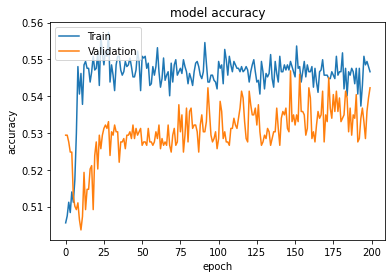

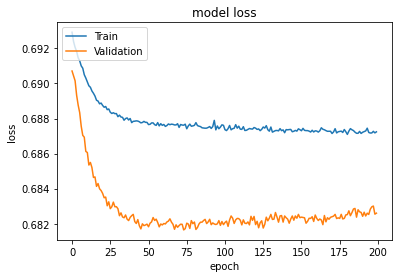

Epoch 1/200
134/134 [==============================] - 1s 4ms/step - loss: 0.6889 - accuracy: 0.5215 - val_loss: 0.6923 - val_accuracy: 0.5211
Epoch 2/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5154 - val_loss: 0.6928 - val_accuracy: 0.5037
Epoch 3/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5154 - val_loss: 0.6930 - val_accuracy: 0.4991
Epoch 4/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5177 - val_loss: 0.6934 - val_accuracy: 0.4926
Epoch 5/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5285 - val_loss: 0.6932 - val_accuracy: 0.5028
Epoch 6/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5289 - val_loss: 0.6928 - val_accuracy: 0.5147
Epoch 7/200
134/134 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5266 - val_loss: 0.6928 - val_accuracy: 0.5239

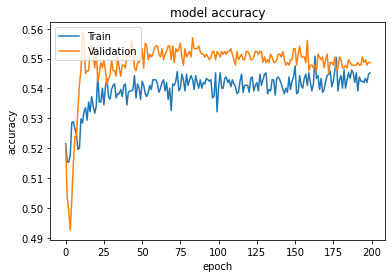

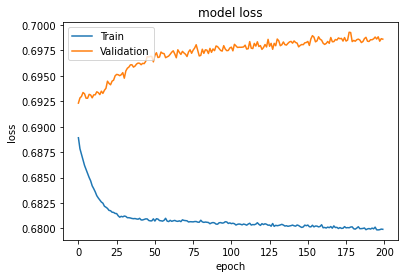

Epoch 1/200
136/136 [==============================] - 1s 4ms/step - loss: 0.6978 - accuracy: 0.5317 - val_loss: 0.7060 - val_accuracy: 0.5028
Epoch 2/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5294 - val_loss: 0.6999 - val_accuracy: 0.4905
Epoch 3/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5285 - val_loss: 0.6975 - val_accuracy: 0.4877
Epoch 4/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5345 - val_loss: 0.6954 - val_accuracy: 0.4934
Epoch 5/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5322 - val_loss: 0.6952 - val_accuracy: 0.4991
Epoch 6/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5335 - val_loss: 0.6949 - val_accuracy: 0.4981
Epoch 7/200
136/136 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5294 - val_loss: 0.6947 - val_accuracy: 0.5009

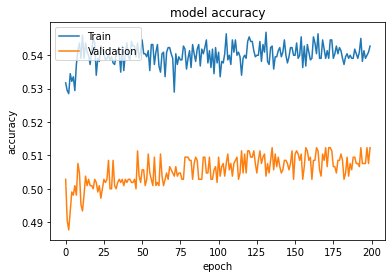

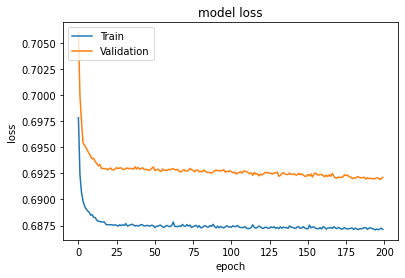

In [22]:
val_accuracy=[]
val_loss=[]
train_accuracy=[]
train_loss=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=cnnmodel()
    history = model.fit(train_features,train_labels,epochs=200,batch_size=16,validation_data=(val_features,val_labels))
    val_accuracy.append(model.evaluate(val_features,val_labels)[1])
    
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [23]:
acc = np.mean(val_accuracy)
acc

0.5344344178835551